<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/CV_%EC%B5%9C%EC%A2%852(g_v).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* AdamP
* lr=0.0001
* batch=32
* epoch=15
* Data Augmentation:Geomentric transform + Visual corruptions


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5981 sha256=2ad2499cbc9f9b5778de6f80bd830ec55d94d3924a5562ba6c77b3120f00410f
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models

from adamp import AdamP
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from torch.utils.data import ConcatDataset
from collections import Counter


# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [4]:
### Custom Dataset ###
# Create DataLoader
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.mode = mode
    self.transform = transform

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [5]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

In [6]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])

transforms_test = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

'''
# 1)Apply RandAugment
transforms_train_rand = transforms.Compose([
    transforms.Resize((448, 448)),
    RandAugment(5,3),
    transforms.ToTensor(),
])
'''

# 2)Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    #transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 32 # or 64

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
#train_set_augmented = CUB2011(mode='train', transform=transforms_train_rand) # 1)
train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v) # 2)

train_loader_b = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

'''
train_set_mixup = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

train_set_mixup = CUB2011(mode='train', transform=train_set_mixup)
'''
'''
# 4) 각 클래스의 샘플 수를 계산
class_counts = Counter([label for _, label in train_set_origin])

# 가장 작은 클래스의 샘플 수를 찾아 minority_class_label로 지정
minority_class_label = min(class_counts, key=class_counts.get)

# Create a new dataset from replicated_data
replicated_data = CUB2011(mode='train', transform=transforms_train_origin)
replicated_data.image_folder = [data for data in replicated_data.image_folder if data[1] == minority_class_label]
'''

#print('Num of each dataset: ',len(train_set_origin),len(replicated_data),
      #len(train_set_augmented),len(train_set_augmented2),len(train_set_mixup))

print('Num of each dataset: ',len(train_set_origin),len(train_set_augmented2))#,len(train_set_augmented)

# 다 합친거
train_set_combined = ConcatDataset([train_set_origin,train_set_augmented2])#train_set_augmented

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  2360 2360
Num of each dataset:  4720 296 298
Loaded dataloader


Batch 1


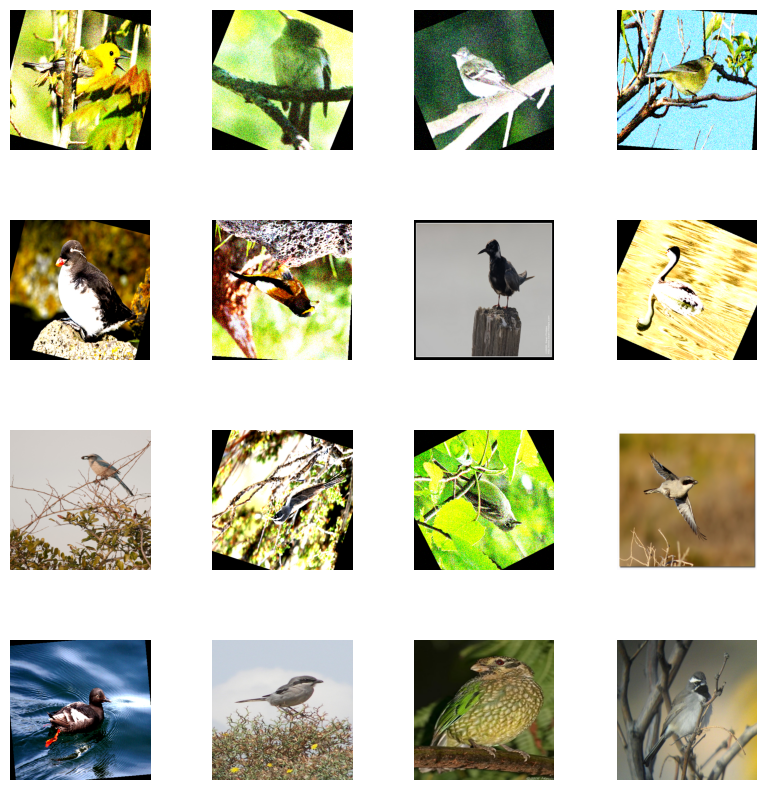

Batch 2


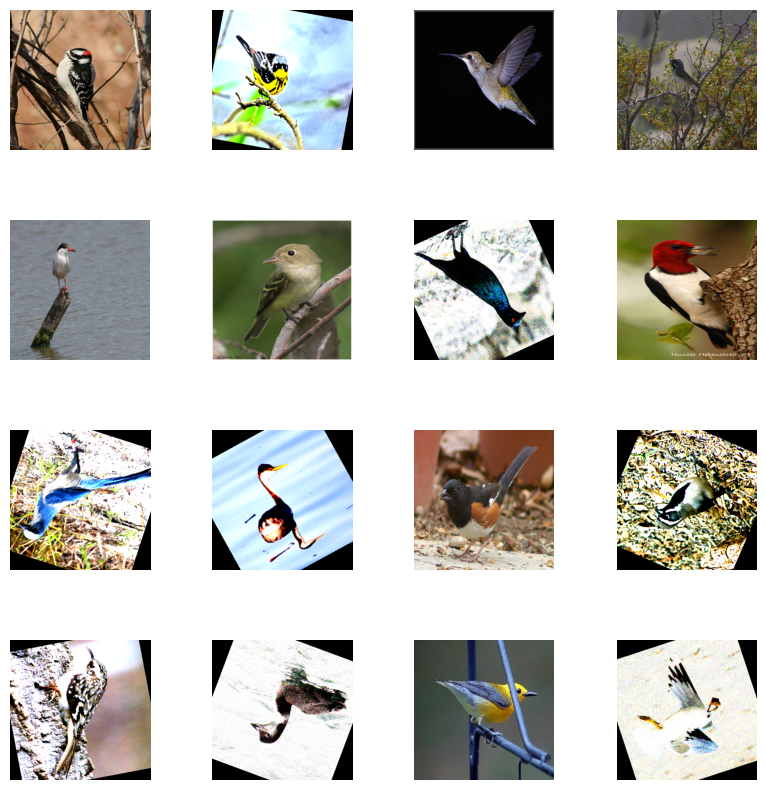

Batch 3


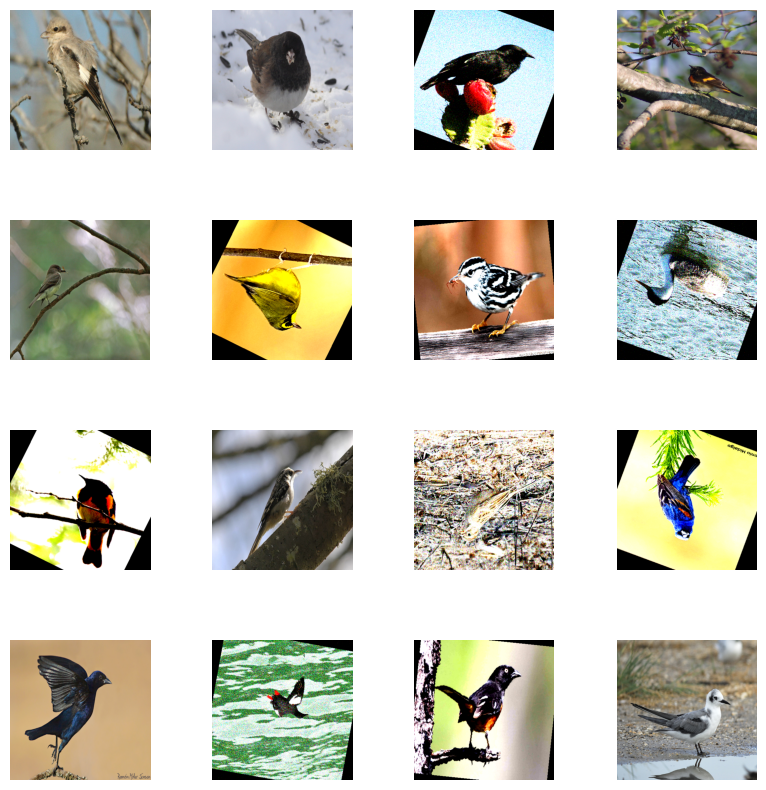

In [7]:
num_rows = 4  # You can change this to the desired number of rows
num_cols = 4  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 3:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images


In [9]:
# 스케줄러 사용
from torch.optim.lr_scheduler import CosineAnnealingLR

### Model / Optimizer ###
EPOCH = 15
lr = 0.0001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
'''
model.fc = nn.Sequential(
    nn.Linear(num_features,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 50)  # 클래스 수에 맞게 조정
)#선택
'''
model.to(DEVICE)

optimizer = AdamP(model.parameters(),lr=lr)

# 스케줄러 초기화 (주기와 최소/최대 학습률 설정)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Created a learning model and optimizer


In [10]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # 스케줄러 업데이트
    #scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [11]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/148]	loss: 4.086900
Train Epoch: 0 [10/148]	loss: 3.717474
Train Epoch: 0 [20/148]	loss: 3.749617
Train Epoch: 0 [30/148]	loss: 3.397055
Train Epoch: 0 [40/148]	loss: 3.235021
Train Epoch: 0 [50/148]	loss: 3.083056
Train Epoch: 0 [60/148]	loss: 2.779055
Train Epoch: 0 [70/148]	loss: 2.760801
Train Epoch: 0 [80/148]	loss: 2.623368
Train Epoch: 0 [90/148]	loss: 2.471010
Train Epoch: 0 [100/148]	loss: 2.186009
Train Epoch: 0 [110/148]	loss: 2.044284
Train Epoch: 0 [120/148]	loss: 2.091537
Train Epoch: 0 [130/148]	loss: 2.048519
Train Epoch: 0 [140/148]	loss: 2.026633
[0]Validation Loss: 1.5946,Accuracy: 70.6081%
Train Epoch: 1 [0/148]	loss: 1.945951
Train Epoch: 1 [10/148]	loss: 1.786817
Train Epoch: 1 [20/148]	loss: 1.728521
Train Epoch: 1 [30/148]	loss: 1.500042
Train Epoch: 1 [40/148]	loss: 1.689784
Train Epoch: 1 [50/148]	loss: 1.472031
Train Epoch: 1 [60/148]	loss: 1.574984
Train Epoch: 1 [70/148]	loss: 1.570706
Train Epoch: 1 [80/148]	loss: 1.132559
Train Epoch: 1 

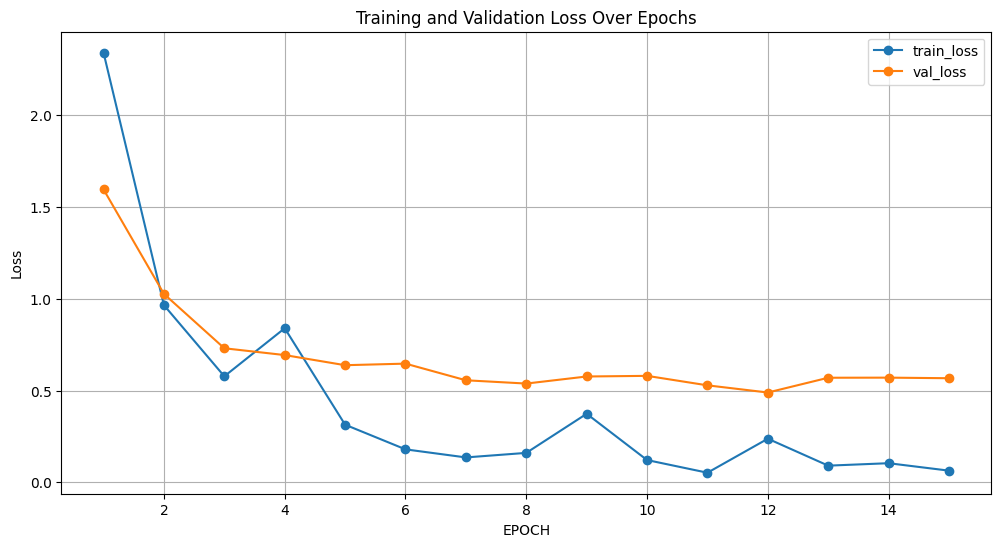

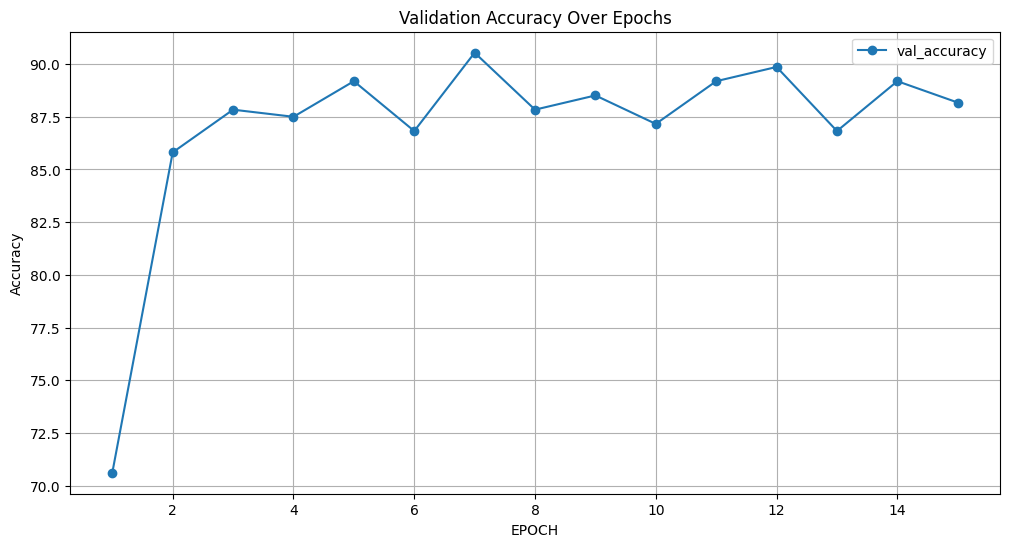

In [12]:
# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

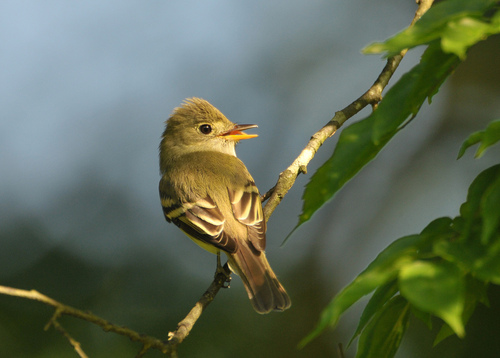

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
img_path = test_set.image_folder[random_index]
img_path = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test',img_path)
display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01532829', 'house_finch', 7.3692126)]


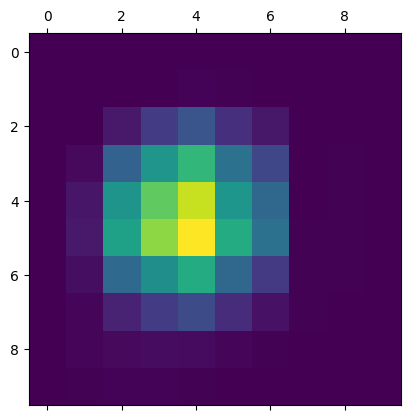

In [17]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-18-8a3df7f2985d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


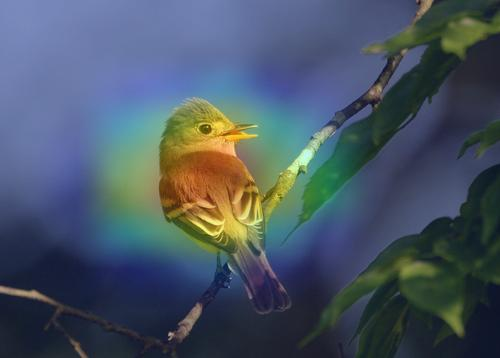

In [18]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)